In [1]:
from kafka import KafkaConsumer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import json
from IPython.display import clear_output

In [2]:
import nltk 
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to
[nltk_data]     /home/ciceromoura/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ciceromoura/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
STOPWORDS = set(stopwords.words('portuguese'))
STOPWORDS2 = ['RT', 'https', 'co']

In [4]:
def remove_stopwords(texto):
    texto_limpo = ' '.join(palavra for palavra in texto.split() if palavra not in STOPWORDS)
    texto_final = ' '.join(palavra for palavra in texto_limpo.split() if palavra not in STOPWORDS2)
    return texto_final

In [5]:
#configuração do kafka
brokers = ['localhost:9092']
topico = 'dados-tweets'

consumer = KafkaConsumer(topico, group_id = 'group1', bootstrap_servers = brokers)

<h1>Nuvem de Palavras</h1>

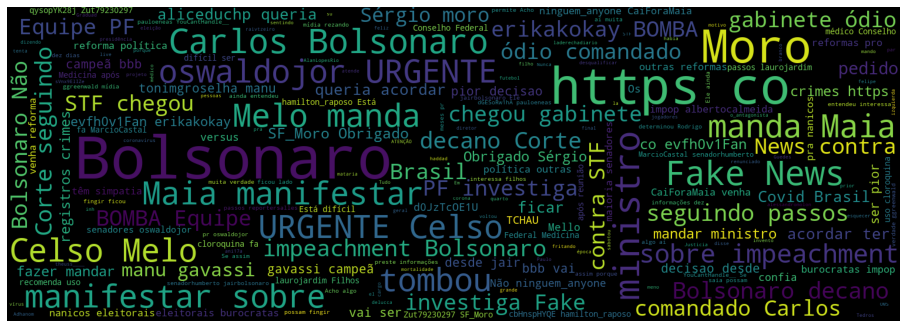

In [ ]:
#geração da nuvem de palavras em tempo real
frases = ''
for messagem in consumer:
    texto = json.loads(messagem.value.decode('utf-8'))
    frases = frases + remove_stopwords(texto['tweet'])
    clear_output()
    wordcloud = WordCloud(max_font_size=100, width = 1520, height = 535).generate(frases)
    plt.figure(figsize=(16,9))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

<h1>PySpark</h1>

In [7]:
from pyspark.sql import SparkSession, SQLContext, Row
import pyspark.sql.functions as f
from operator import add

In [8]:
def init_spark():
    spark = SparkSession.builder.appName("Tweets").getOrCreate()
    sc = spark.sparkContext
    sql = SQLContext(sc)
    return spark, sc, sql

In [9]:
spark, sc, sql = init_spark()

In [10]:
frases = frases.lower()
lista_palavras = frases.split()

In [11]:
rdd1 = sc.parallelize(lista_palavras)
row_rdd = rdd1.map(lambda x: Row(x))
df = sql.createDataFrame(row_rdd,['palavras'])
df.show()

+----------------+
|        palavras|
+----------------+
|              rt|
|@ninguem_anyone:|
|    #caiforamaia|
|               e|
|             que|
|           venha|
|               a|
|         reforma|
|        política|
|               e|
|          outras|
|        reformas|
|             pro|
|         brasil,|
|             pra|
|             que|
|         nanicos|
|      eleitorais|
|               e|
|      burocratas|
+----------------+
only showing top 20 rows



In [12]:
df.withColumn('word', f.explode(f.split(f.col('palavras'), ' '))).groupBy('word').count().sort('count', ascending=False).show()

+----------+-----+
|      word|count|
+----------+-----+
|       que|   12|
|        de|    9|
|       não|    8|
| bolsonaro|    7|
|         o|    7|
|       por|    5|
|         e|    5|
|        da|    5|
|bolsonaro.|    4|
|        os|    4|
|       stf|    4|
|      está|    4|
|     sobre|    3|
|     moro.|    3|
|        se|    3|
|        ao|    3|
|       tem|    3|
|         a|    3|
|        do|    3|
|     celso|    3|
+----------+-----+
only showing top 20 rows



In [13]:
palavras_contadas = sc.parallelize(lista_palavras).map(lambda word: (word, 1)).reduceByKey(add)

In [14]:
palavras_contadas.saveAsTextFile('teste')

In [15]:
palavras_contadas.collect()

[('rt', 1),
 ('@ninguem_anyone:', 1),
 ('#caiforamaia', 1),
 ('e', 5),
 ('que', 12),
 ('venha', 1),
 ('a', 3),
 ('reforma', 1),
 ('política', 1),
 ('outras', 1),
 ('reformas', 1),
 ('pro', 1),
 ('brasil,', 1),
 ('pra', 1),
 ('nanicos', 1),
 ('eleitorais', 1),
 ('burocratas', 1),
 ('impop…rt', 1),
 ('@albertocalmeida:', 1),
 ('moro:', 1),
 ('tchau', 1),
 ('stf', 4),
 ('bolsonaro', 7),
 ('não', 8),
 ('confia', 1),
 ('em', 2),
 ('moro.', 3),
 ('os', 4),
 ('ministros', 1),
 ('do', 3),
 ('têm', 1),
 ('simpatia', 1),
 ('por', 5),
 ('maioria', 1),
 ('dos', 3),
 ('senadores', 1),
 ('n…rt', 1),
 ('@oswaldojor:', 2),
 ('urgente:', 2),
 ('celso', 3),
 ('de', 9),
 ('melo', 2),
 ('manda', 2),
 ('maia', 3),
 ('se', 3),
 ('manifestar', 2),
 ('sobre', 3),
 ('impeachment', 2),
 ('bolsonaro.', 4),
 ('o', 7),
 ('decano', 2),
 ('da', 5),
 ('corte', 2),
 ('está', 4),
 ('seguindo', 2),
 ('passos', 2),
 ('d…rt', 3),
 ('@laurojardim:', 1),
 ('filhos', 2),
 ('versus', 1),
 ('https://t.co/d0jztcoe1u', 1),
 ('ht